In [21]:
# Import modules.
import os
import matplotlib.pyplot as mp

# Import tools for keras.
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from librosa.display import waveplot
from collections import namedtuple, OrderedDict

from scipy import stats

import datetime
import time

import tensorflow.contrib.eager as tfe

In [22]:
tf.enable_eager_execution()

In [23]:
d = '2019-02-14' # datetime.datetime.now().date().isoformat()
project_dir     = './GAN_{}'.format(d)
checkpoint_dir  = os.path.join(project_dir, './checkpoints')
images_dir      = os.path.join(project_dir, './images'     )
diagnostics_dir = os.path.join(project_dir, './diagnostics')

In [24]:
import importlib.util
spec       = importlib.util.spec_from_file_location("GAN", os.path.join(project_dir, 'GAN.py'))
GAN_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(GAN_module)
GAN        = GAN_module.GAN

In [25]:
from imp import reload
import SeisUtils
reload(SeisUtils)

<module 'SeisUtils' from 'C:\\Users\\micha\\Documents\\CS101\\seis-GAN\\SeisUtils.py'>

In [26]:
from SeisUtils import extract_func
from SeisUtils import SeisData
from SeisUtils import SeisGenerator
# from GAN       import GAN

In [27]:
# Import data.
data        = SeisData()
f           = data.f            # h5 dictionary
meta        = data.meta         # meta info (13, 260764) includes 'dist' and 'magn'
wform_names = data.wform_names  # names (e.g '/proj..japan...446.UD')
wform       = data.wform        # wave forms - (3, 10500, 260764)
metad       = data.metad        # { 'dist' : [...], 'magn' : [...] } (distance and magnitude dict for easier access)

In [ ]:
# Define data generator.
BATCH_SIZE  = 4
weights     = (1 / metad['dist']) * np.min(metad['dist'])
extract_f   = extract_func(data_format = gan.data_format, burn_seconds = 5, input_seconds = 5, output_seconds = 4)
SG_test     = SeisGenerator(wform, BATCH_SIZE, extract_f, indeces = testIdx , verbose = True, shuffle = False, expend = True)
SG_valid    = SeisGenerator(wform, BATCH_SIZE, extract_f, indeces = validIdx, verbose = True, shuffle = True)
SG_train    = SeisGenerator(wform, BATCH_SIZE, extract_f, indeces = trainIdx, verbose = True, shuffle = True)
print('Testing    Samples:', len(SG_test ))
print('Validation Samples:', len(SG_valid))
print('Training   Samples:', len(SG_train))

In [28]:
gan           = GAN(data_format = 'channels_last') 
generator     = gan.generator
discriminator = gan.discriminator

In [29]:
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)
generator_optimizer     = tf.train.AdamOptimizer(1e-4)

In [30]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint        = tf.train.Checkpoint(generator_optimizer     = generator_optimizer,
                                        discriminator_optimizer = discriminator_optimizer,
                                        generator               = generator,
                                        discriminator           = discriminator)
print('Checkpoint:', checkpoint._update_uid)

Checkpoint: -1


In [31]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
np.random.seed(7)
num_examples_to_generate = 4
random_vector_for_generation = tf.random_normal([num_examples_to_generate, 3, gan.noise_dim]) if gan.data_format == 'channels_first' else tf.random_normal([num_examples_to_generate, gan.noise_dim, 3])
def latent(num_examples_to_generate = 4): return tf.random_normal([num_examples_to_generate, 3, gan.noise_dim]) if gan.data_format == 'channels_first' else tf.random_normal([num_examples_to_generate, gan.noise_dim, 3])

In [32]:
def plot_wforms(w, figsize = (40,10), ylabels = None):
    if isinstance(w, tf.Tensor): w = w.numpy()
    N = w.shape[0] if len(w.shape) > 2 else 1
    fig, axs = plt.subplots(N, 3, figsize = figsize)
    for i in range(N):
        for j in range(3):
            ax = axs[i, j] if N > 1 else axs[j]
            if N > 1:
                ax.plot(w[i, :, j]) 
            else:
                ax.plot(w[:, j])
    for i in range(N):
        ax = axs[i, 0] if N > 1 else axs[0]
        ax.set_ylabel(ylabels[i] if ylabels is not None else 'velocity')
    for j in range(3):
        ax = axs[N-1, j] if N > 1 else axs[j]
        ax.set_xlabel('channel {}'.format(j + 1))
    return fig
        
def plot_wprobs(w, figsize = (10,10)):
    if isinstance(w, tf.Tensor): w = w.numpy()
    N = w.shape[0] if len(w.shape) > 2 else 1
    fig = plt.figure(figsize = figsize)
    for i in range(N):
        for j in range(3):
            plt.subplot(N, 3, i*3 + j + 1)
            if N > 1:
                stats.probplot(w[i, :, j], plot = mp)
            else:
                stats.probplot(w[:, j], plot = mp)
    for i in range(N):
        plt.subplot(N, 3, i*3 + 1)
        plt.ylabel('pred {}'.format(i))
    for j in range(3):
        plt.subplot(N, 3, (N-1)*3 + j + 1)
        plt.xlabel('channel {}'.format(j + 1))
        

In [33]:
restore_path = tf.train.latest_checkpoint(checkpoint_dir)
status = checkpoint.restore(restore_path)
status.assert_existing_objects_matched()
print('Checkpoint:', checkpoint.save_counter.numpy())

Checkpoint: 173


In [34]:
# # Load diagnositics. 
# diagnostic = namedtuple('diagnostic', 'array, name')

# diagnostics = [
#     OrderedDict([
#         ('gen_grads_norms.npy', 'Generator: Gradient Norms'),
#         ('gen_losses.npy'     , 'Generator: Loss Values'   ),
#         ('gen_accuracy.npy'   , 'Generator: Accuracy'      )
#     ]), 
#     OrderedDict([
#         ('dis_grads_norms.npy', 'Discriminator: Gradient Norms'),
#         ('dis_losses.npy'     , 'Discriminator: Loss Values'   ),
#         ('dis_accuracy.npy'   , 'Discriminator: Accuracy'      )
#     ])
# ]

# diagnostics = [ [diagnostic(np.load(os.path.join(diagnostics_dir, path)), name) for path, name in dd.items()] for dd in diagnostics ]

# for ds in diagnostics:
#    for d in ds:
#     print(d.name, d.array.shape)  

In [35]:
# n = len(diagnostics)
# m = len(diagnostics[0])
# fig, axs = plt.subplots(n, m, figsize = (30, 10))
# for i, ds in enumerate(diagnostics):
#     for j, d in enumerate(ds):
#         ax = axs[i, j]
#         ax.plot(d.array)
#         ax.set_xlabel('batch')
#         ax.set_title(d.name)
#         ax.set_ylabel(d.name.split(':')[1])
# # fig.savefig(os.path.join(project_dir, 'diagnostics_at_epic_{}.png'.format(checkpoint.save_counter.numpy())))

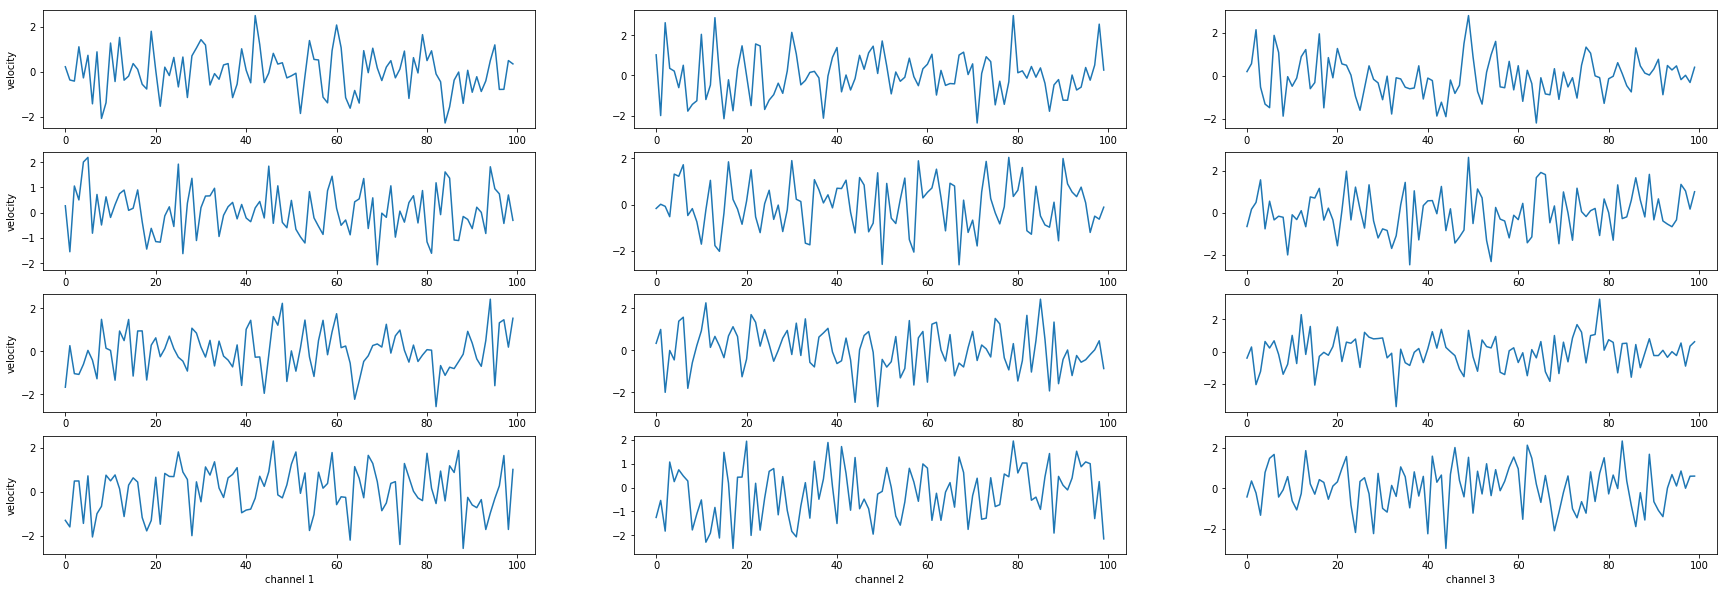

In [36]:
plot_wforms(random_vector_for_generation[:, :, :], figsize = (30, 10));

In [37]:
extract_f = extract_func(data_format = 'channels_last', input_seconds = 5, output_seconds = 4)
np.random.seed(30)

N = 4
idx = np.random.choice(range(wform.shape[2]), N)
idx .sort()

In [38]:
x, y = extract_f(wform[:, :, idx])
# plot_wforms(y, figsize = (30, 10));

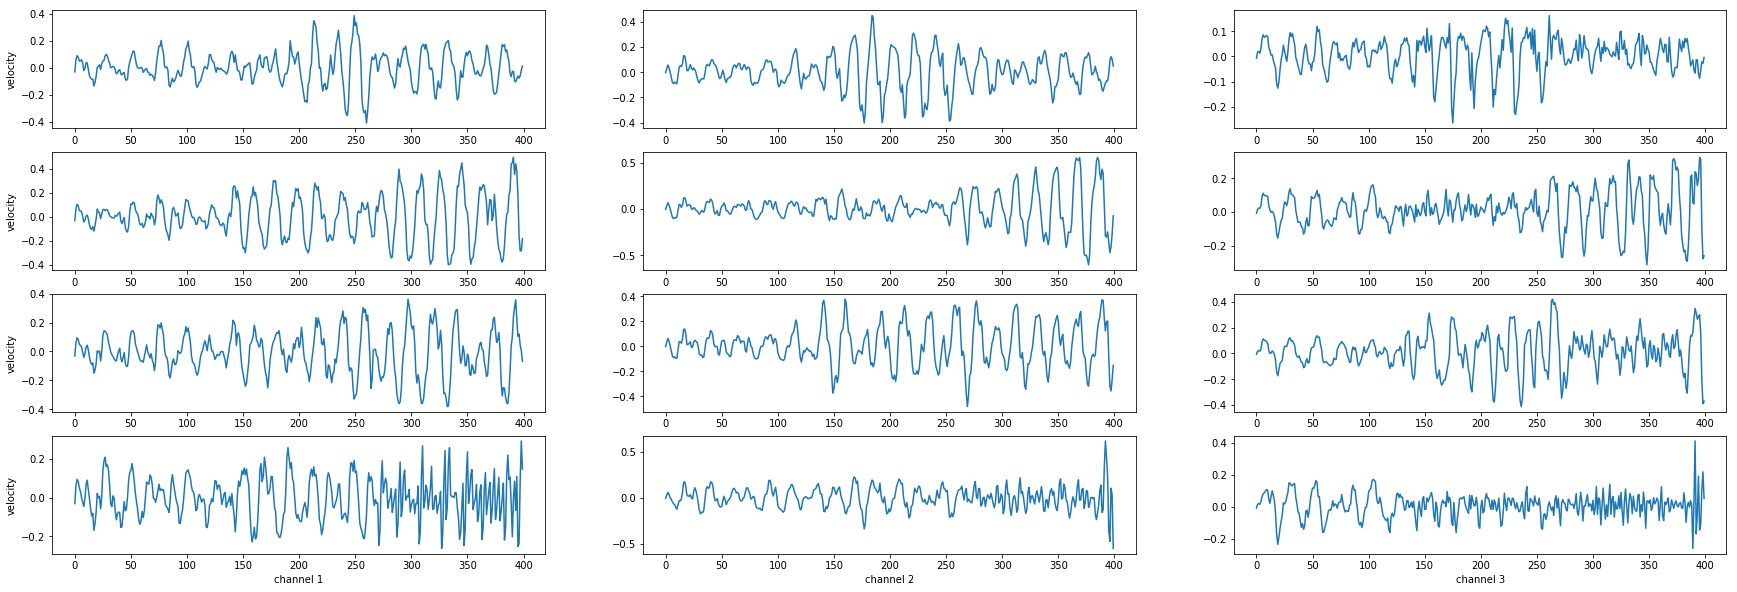

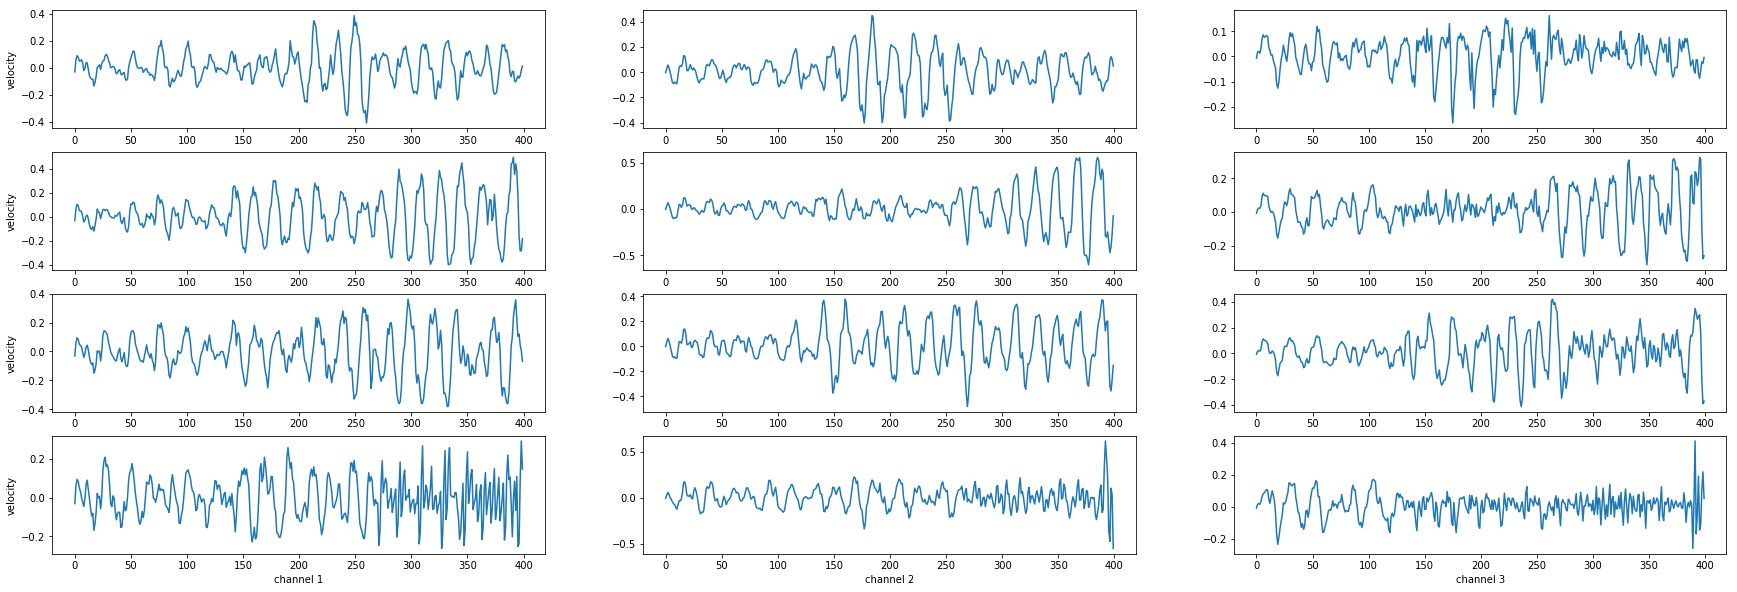

In [39]:
predgen = generator(latent(N), training = False)[:, :, 0, :]
plot_wforms(predgen, figsize = (30, 10))

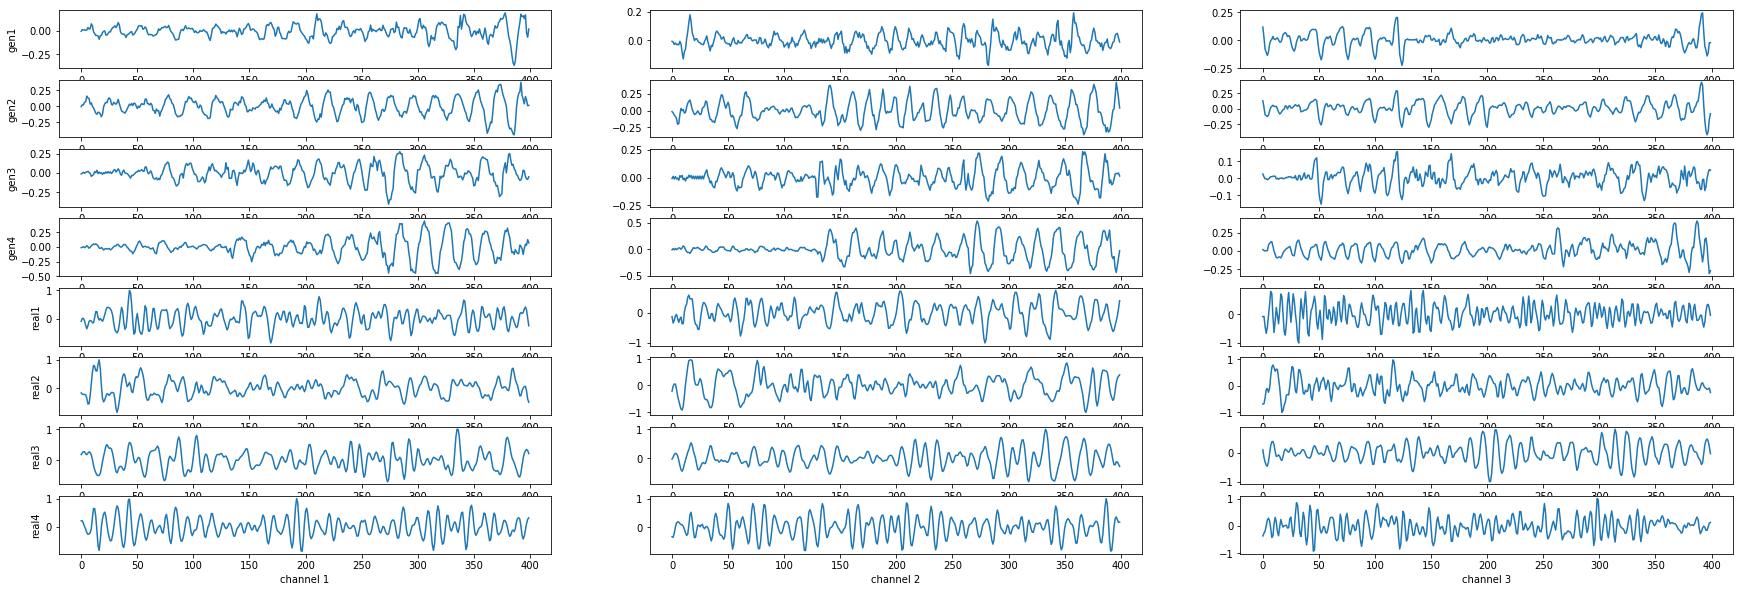

In [20]:
fig = plot_wforms(np.vstack([predgen, y]), figsize = (30, 10), ylabels = ['gen' + str(i+1) for i in range(N)] + ['real' + str(i+1) for i in range(N)] )
fig.savefig(os.path.join(project_dir, 'generated_wforms_at_epic_{}.png'.format(checkpoint.save_counter.numpy())))

In [21]:
fake_input  = generator(latent(), training = False)
real_input  = tf.convert_to_tensor(y[:, :, None, :])
fake_logits = discriminator(fake_input, training = False)
real_logits = discriminator(real_input, training = False)

In [22]:
print(fake_logits)
print(real_logits)

tf.Tensor(
[[0.46464136]
 [0.50576466]
 [0.47753534]
 [0.46570382]], shape=(4, 1), dtype=float32)
tf.Tensor(
[[0.4826846 ]
 [0.46169695]
 [0.46182373]
 [0.5038293 ]], shape=(4, 1), dtype=float32)


In [23]:
epsilon      = tf.random_uniform([], 0, 1)
mixed_input  = (epsilon * real_input) + (1 - epsilon) * fake_input
mixed_output = discriminator(mixed_input, training = True)

In [24]:
tf.math.NaN

AttributeError: module 'tensorflow.math' has no attribute 'NaN'

In [ ]:
tf.constant(np.nan)

In [ ]:
# N = len(predgenn1) 
# fig, axs = plt.subplots(N, 3, figsize = (30,10))
# for i in range(N):
#     for j in range(3):
#         ax = axs[i, j] if N > 1 else axs[j]
#         ax.plot(predgenn1[i][:, j]) 
# for i in range(N):
#     ax = axs[i, 0] if N > 1 else axs[0]
#     ax.set_ylabel('pred {}'.format(i))
# for j in range(3):
#     ax = axs[N-1, j] if N > 1 else axs[j]
#     ax.set_xlabel('channel {}'.format(j + 1))

In [ ]:
predgen2 = checkpoint.generator(random_vector_for_generation, training = False)
predgenn2 = [x[0, ...].numpy() for x in predgen2]
# plot_wforms(np.exp(predgen), figsize = (30, 10))

In [ ]:
plot_wforms(wforms[:,:, 0].transpose((2, 1, 0))[:, :, None, :], figsize = (30, 10))

In [ ]:
# N = len(predgenn2) 
# fig, axs = plt.subplots(N, 3, figsize = (30,10))
# for i in range(N):
#     for j in range(3):
#         ax = axs[i, j] if N > 1 else axs[j]
#         ax.plot(predgenn2[i][:, j]) 
# for i in range(N):
#     ax = axs[i, 0] if N > 1 else axs[0]
#     ax.set_ylabel('pred {}'.format(i))
# for j in range(3):
#     ax = axs[N-1, j] if N > 1 else axs[j]
#     ax.set_xlabel('channel {}'.format(j + 1))

In [ ]:
# # Divide data into train and test set.
# def extract_func(burn_seconds = 5, input_seconds = 10, output_seconds = None, data_format = 'channels_first', normalize = True):
    
#     def wrapper(data):

  
#         # Take first part of wave form after the burn-in period for input. Take the max of the remaining sequence for output.
#         iburn   = int(burn_seconds   * 100 - 1    )
#         itime1  = int(input_seconds  * 100 + iburn)
#         itime2  = int(output_seconds * 100 + itime1 if output_seconds is not None else -1)
#         x       = data[:, iburn:itime1 , : ]
#         y       = data[:, itime1:itime2, : ]
        
#         y = y / np.max(np.abs(y), axis = 1)[:, None, :]  
        
#         x = x.transpose((2,0,1))
#         y = y.transpose((2,0,1))
        

#         return (x, y) if data_format == 'channels_first' else (x.transpose((0, 2, 1)), y.transpose((0, 2, 1)))
    
#     return wrapper


In [ ]:
extract_f = extract_func(data_format = 'channels_last', input_seconds = 5, output_seconds = 4)
plot_wforms(y, figsize = (30, 10))

In [ ]:
y = wform[:, 999:1399, idx].transpose((2, 1, 0))
y = y / np.max(np.abs(y), axis = 1)[:, None, :]
print(np.max(np.abs(y), axis = 1)[:, None, :])
plot_wforms(y, figsize = (30, 10))

In [ ]:
x = wform[:, 1001:2201, 0:4].transpose((2, 1, 0))
plot_wprobs(np.log(np.abs(x)), figsize = (30, 10))

In [ ]:
x = wform[:, 1001:2201, 0:4].transpose((2, 1, 0))
plot_wforms(1/(1+np.exp(-x)), figsize = (30, 10))

In [ ]:
np.random.normal(0, 0.1, [2,4])

In [ ]:
wform[:, 1001:2201, 0:4].transpose((2, 1, 0)).shape

In [ ]:
random_vector_for_generation.shape

In [ ]:
import glob
import imageio

In [ ]:
gifname = os.path.join(project_dir, 'dcgan')
with imageio.get_writer('{}.gif'.format(gifname), mode = 'I') as writer:
    
  filenames = glob.glob(os.path.join(image_dir, 'image*.png'))
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp {}.gif {}.gif.png'.format(gifname))

In [ ]:
name = os.path.join(project_dir, 'dcgan')

In [ ]:
name

In [ ]:
min(metad['magn'])

In [ ]:
np.sum([np.product(v.shape.as_list()) for v in generator.variables])

In [ ]:
np.product([1,2,3,4])

In [ ]:
np.sum([np.prod(v.shape.as_list()) for v in generator.variables])
np.sum([np.prod(v.shape.as_list()) for v in discriminator.variables])

In [21]:
import tensorflow as tf

# ### build the graph
# ## first set up the parameters
# m = tf.get_variable("m", [], initializer=tf.constant_initializer(0.))
# b = tf.get_variable("b", [], initializer=tf.constant_initializer(0.))
# init = tf.global_variables_initializer()

## then set up the computations
input_placeholder = tf.placeholder(tf.float32)
output_placeholder = tf.placeholder(tf.float32)

x = input_placeholder
y = output_placeholder
y_guess = m * x + b

loss = tf.square(y - y_guess)

## finally, set up the optimizer and minimization node
optimizer = tf.train.GradientDescentOptimizer(1e-3)
train_op = optimizer.minimize(loss)

### start the session
sess = tf.Session()
sess.run(init)


In [22]:
input_placeholder.name

'Placeholder_2:0'

In [25]:
### perform the training loop
import random

## set up problem
true_m = random.random()
true_b = random.random()

for update_i in range(10):
  ## (1) get the input and output
  input_data = random.random()
  output_data = true_m * input_data + true_b

  ## (2), (3), and (4) all take place within a single call to sess.run()!
  _train_op = sess.run([train_op], feed_dict={input_placeholder.name: input_data, output_placeholder: output_data})
    
#   _loss, _ = sess.run([loss, train_op], feed_dict={input_placeholder: input_data, output_placeholder: output_data})
#   print update_i, _loss

  print(_train_op)

### finally, print out the values we learned for our two variables
print("True parameters:     m=%.4f, b=%.4f" % (true_m, true_b))
print("Learned parameters:  m=%.4f, b=%.4f" % tuple(sess.run([m, b])))

[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
True parameters:     m=0.7780, b=0.5663
Learned parameters:  m=0.0599, b=0.1038


In [32]:
two_node   = tf.constant(4)
print_op   = tf.Print(two_node, [two_node])
three_node = tf.constant(3)
with tf.control_dependencies([print_op]):
    sum_node   = two_node + three_node
### this new copy of two_node is not on the computation path, so nothing prints!
sess = tf.Session()
print(sess.run([sum_node, print_op]))

[7, 4]


In [43]:
3 % 500 

3